# Preparation steps

# I. Import necessary modules

* `import os`: to read files from disk
* `import cv2`: OpenCV is an image and video processing library  
* `import matplotlib.pyplot as plt` and `import seaborn as sn`: to show images and graphs
* `from random import randint`: to show random images
* `import numpy as np`: linear algebra; all images will represent numpy-arrays.
* other modules and their components will be imported later.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sn

import cv2
from random import randint

import numpy as np

# I. Check data 

First, check the number of files in every gemstone class in folder `/kaggle/input/gemstones-images`. Images are already divided into train (~2,800 images) and test (~400 images) data. Each class in train set contains `27 - 47` images, in test set - `4 - 6` images.
* create list `CLASSES` which contains the names of 87 classes of gemstones based on folders names;
* plot the distribution of data;
* *uncomment block of code if you want a text output about each subfolder*.

87 classes with 3219 images in total


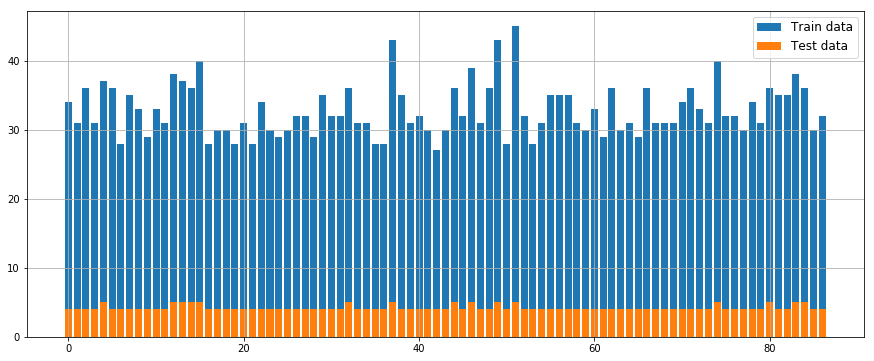

In [2]:
CLASSES, gems = [], [] # names of classes, count of images for each class

for root, dirs, files in os.walk('/kaggle/input/gemstones-images'):
    f = os.path.basename(root)    # get class name - Amethyst, Onyx, etc    
        
    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f) # add folder name
    
    # uncomment this block if you want a text output about each subfolder
    #count_dirs = 0
    #for f in dirs:           # count subfolders
        #count_dirs += 1
    #depth = root.split(os.sep)
    #print((len(depth) - 2) * '--'+'>', '{}:\t {} folders, {} imgs'.format(os.path.basename(root), count_dirs, gems[-1] if gems!=[] else 0)) 
    
gems_count = len(CLASSES) # 87 = number of classes
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

f, ax = plt.subplots(figsize=(15,6))
if(gems[0])<10:
    plt.bar(range(gems_count), gems[gems_count:], label = 'Train data')
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Test data')
else:
    plt.bar(range(gems_count), gems[0:gems_count], label = 'Train data')
    plt.bar(range(gems_count), gems[gems_count:], label = 'Test data')
ax.grid()
ax.legend(fontsize = 12);

Orange small bars represent test data and blue bars represent train data. Data is normally distributed.

# II. Prepare training data

## 1. Prepare parameters

* resize processed images to `img_w, img_h` - this option will be used when cropped and as a parameter of neural network; 
* provide train directory path.

In [3]:
img_w, img_h = 220, 220    # width and height of image
train_dir = '/kaggle/input/gemstones-images/train/'

## 2. Create function which reads images and class names
* this function will be also used with test images;
* read each image from disk using `cv2` and resize it to `img_w*1.5, img_h*1.5`;
* set `cv2.COLOR_BGR2RGB` option because opencv reads and displays an image as BGR color format instead of RGB color format. Without this option images will be shown in blue hue because `matplotlib` uses RGB to display image;
* create a list of class names while reading folders - `Amethyst, Onyx, etc`;
* when `Images` list is ready - convert it to Numpy array;
* return tuple of 2 elements: Images and corresponding Labels.

In [4]:
def read_imgs_lbls(_dir):
    Images, Labels = [], []
    for root, dirs, files in os.walk(_dir):
        f = os.path.basename(root)  # get class name - Amethyst, Onyx, etc       
        for file in files:
            Labels.append(f)
            try:
                image = cv2.imread(root+'/'+file)              # read the image (OpenCV)
                image = cv2.resize(image,(int(img_w*1.5), int(img_h*1.5)))       # resize the image (images are different sizes)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts an image from BGR color space to RGB
                Images.append(image)
            except Exception as e:
                print(e)
    Images = np.array(Images)
    return (Images, Labels)

## 3. Create function which converts string labels to numbers
* Convert string labels to a list of numbers using list `CLASSES`. The index will represent label of class, f.e. *Ruby = 0, Amethyst = 24*, etc.
* when `Labels` list is ready - convert it to Numpy array.

In [5]:
def get_class_index(Labels):
    for i, n in enumerate(Labels):
        for j, k in enumerate(CLASSES):    # foreach CLASSES
            if n == k:
                Labels[i] = j
    Labels = np.array(Labels)
    return Labels

## 4. Fill arrays of Images and corresponding Labels with data
* Create two arrays `Train_Imgs, Train_Lbls` which contain images and corresponding names of classes of gemstones respectively;
* Convert `Train_Lbls` with strings to list with corresponding numbers;
* print the dimensions of both numpy arrays: `Train_Imgs` which stores pictures is 4-dimensional: **Number of images x Width of image x Height of image x Channel of image**.

In [6]:
Train_Imgs, Train_Lbls = read_imgs_lbls(train_dir)
Train_Lbls = get_class_index(Train_Lbls)
print('Shape of train images: {}'.format(Train_Imgs.shape))
print('Shape of train labels: {}'.format(Train_Lbls.shape))

Shape of train images: (2856, 330, 330, 3)
Shape of train labels: (2856,)


## 5. Plot images and their labels for preview
* Using `matplotlib` and `random` show 16 (4x4) random images from the set and their labels (as string and as int number).

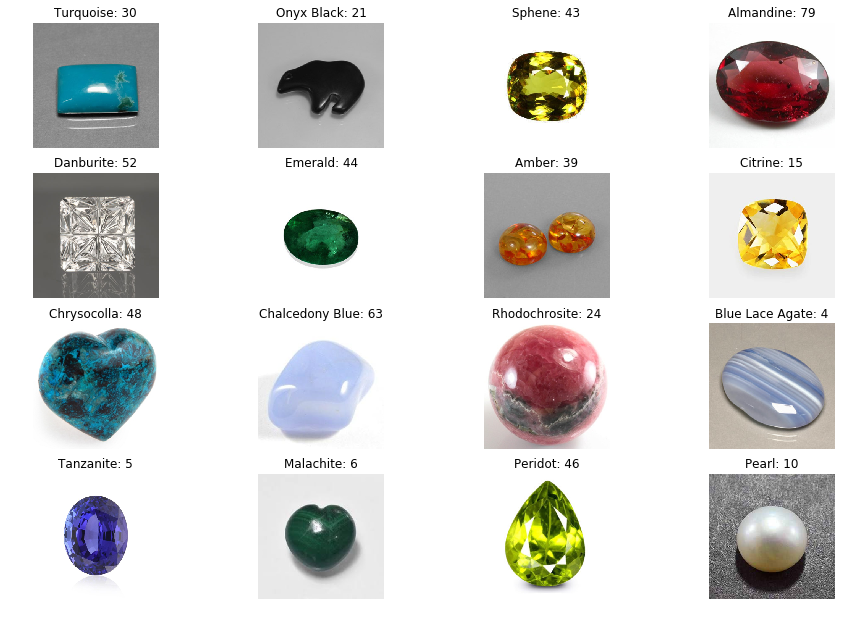

In [7]:
dim = 4 #you can change it;  4x4 dimension flat plot

f,ax = plt.subplots(dim,dim) 
f.subplots_adjust(0,0,2,2)
for i in range(0,dim):
    for j in range(0,dim):
        rnd_number = randint(0,len(Train_Imgs))
        cl = Train_Lbls[rnd_number]
        ax[i,j].imshow(Train_Imgs[rnd_number])
        ax[i,j].set_title(CLASSES[cl]+': ' + str(cl))
        ax[i,j].axis('off')

From 4x4 plot above we can see that gemstones are mostly centered; but let's try to crop the edges.

## 6. Crop edges of images using Canny algorithm
> Canny is a popular edge detection algorithm, which detects the edges of objects present in an image.

* Using `cv2.Canny` find the array representing frame which is the edges how the original picture will be cut;
* Function `edge_and_cut(img)` receives single image and returns a **cropped image (`new_img`)** of the size `img_w, img_h`;
* sometimes Canny algo cannot detect edges (f.e. when the object has almost same color as background) so array `edges` will be zero-valued. In this case use original image.

In [8]:
def edge_and_cut(img):
    try:
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):           
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            
            new_img = img[y1:y2, x1:x2]           # crop the region
            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert back
        else:
            new_img = cv2.resize(img,(img_w, img_h))
    
    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

## 7. Show cropped images
* Function `show_cropped` is kind-of duplicate `edge_and_cut()`: it shows same random examples of Canny algo work: **original image, Canny edges, image with bounding box, cropped image** for better understanding how Canny algo works.

In [9]:
def show_cropped(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)   

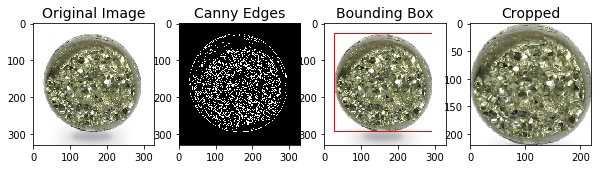

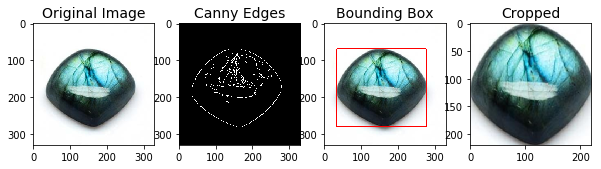

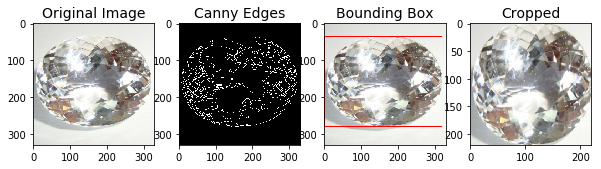

In [10]:
for x in range(0,3):
    show_cropped(Train_Imgs[randint(0,len(Train_Imgs))])

## 8. Replace train images with cropped images
* Create function which calls `edge_and_cut` and replaces `Train_Imgs` numpy array with array of cropped images. Don't forget that images that cannot be cropped will be replced with originals;
* Make sure the shape of final array is the same: NUMBER OF IMAGES x img_w x img_h x 3 (CHANNELS):

In [11]:
def crop_images(Imgs):
    CroppedImages = np.ndarray(shape=(len(Imgs), img_w, img_h, 3), dtype=np.int)

    ind = 0
    for im in Imgs: 
        x = edge_and_cut(im)
        CroppedImages[ind] = x
        ind += 1

    return CroppedImages

In [12]:
Train_Imgs = crop_images(Train_Imgs)
print('Final shape of images in train set: {} '.format(Train_Imgs.shape))

Final shape of images in train set: (2856, 220, 220, 3) 


## 9. Split data into train and validation sets
* use `sklearn` to split `Train_Imgs`, `Train_Lbls` into train (80%) and validation (20%) sets. **Important!**

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(Train_Imgs, Train_Lbls, shuffle = True, test_size = 0.2, random_state = 42)
print('Shape of X_train: {}, y_train: {} '.format(X_train.shape, y_train.shape))
print('Shape of X_val: {}, y_val: {} '.format(X_val.shape, y_val.shape))

Shape of X_train: (2284, 220, 220, 3), y_train: (2284,) 
Shape of X_val: (572, 220, 220, 3), y_val: (572,) 


# III. Prepare for model creation
## 1. Check devices

Using `tensorflow` check which devices uses the Kaggle platform.

`XLA_CPU device`: CPU  
`XLA_GPU device`: Tesla P100-PCIE-16GB (to accelerate computing use GPU mode).  
XLA stands for *accelerated linear algebra*. It's Tensorflow's relatively optimizing compiler that can further speed up ML models.  

Run this notebook with GPU mode: for example, using image size 190 x 190 and basic architecture of CNN mentioned above every epoch on CPU takes ~3 minutes, on GPU ~ 15 sec.

In [14]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14674815769780334566
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13652998349517594717
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7516072112876952767
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15884314215
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1227362034613172935
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


## 2. Import keras
Keras is an open-source neural-network library written in Python which is capable of running on top of **TensorFlow**.
From Keras needed:
* `models` - type of models, import only `Sequential` 
* `layers` - layers corresponding to our model: as it a simple one take only `Conv2D`, `MaxPooling2D` and `AveragePooling2D`
* `optimizers` - contains back propagation algorithms
* `ImageDataGenerator` - for image augmenation (there are not so many samples of each class)

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

Using TensorFlow backend.


# Build a simple CNN  
CNN (Convolutional neural network or ConvNet) is a class of deep neural networks, commonly applied to analyzing visual imagery. Here is the simpliest example of CNN with few layers using `Conv2D` - 2D convolution layer (spatial convolution over images) and `MaxPooling2D` - application of a moving window across a 2D input space.

# I. Provide Hyperparameters
Hyperparameters are set before training; they represent the variables which determines the neural network structure and how the it is trained.  
  
## 1. Parameters for layers
* Convolutional layer filter size (`filters`). The number of filters should depend on the complexity of dataset and the depth of neural network. A common setting to start with is [32, 64, 128] for three layers.  
* `kernel_size` = number of filters  = a small window of pixels at a time (3×3) which will be moved until the entire image is scanned. If images are smaller than 128×128, work with smaller filters of 1×1;
* Width and Height of images were already provided. 2D convolutional layers take a three-dimensional input, typically an image with three color channels;
* `max_pool` = max pooling is the application of a moving window across a 2D input space, where the maximum value within that window is the output: 2x2. 

In [16]:
filters = 32      # the dimensionality of the output space
kernel_size = 3   # length of the 2D convolution window
max_pool = 2      # size of the max pooling windows

## 2. Parameters to fit the model
* **epoch** describes the number of times the algorithm sees the ENTIRE dataset. Each time the algo has seen all samples in the dataset, an epoch has completed.  
* since one epoch is too big to feed to the memory at once divide it in several smaller **batches**. Batch size is always factor of 2. 
* **Iterations** per epoch = number of passes, each pass using batch size number of examples.   

So if we have ~2200 (80%) training samples, and batch size is 32, then it will take ~70 iterations to complete 1 epoch.

In [17]:
EPOCHS = 70                                  # while testing you can change it
batch_size = 32                              # number of training samples using in each mini batch during GD (gradient descent) 
iter_per_epoch = len(X_train) // batch_size  # each sample will be passed [iter_per_epoch] times during training
val_per_epoch = len(X_val) // batch_size     # each sample will be passed [val_per_epoch] times during validation

# II. Provide a model

## 1. Architect a model
The Sequential model is a linear stack of layers.
* I use a kind of VGG network architecture:

|   |       Layers       |
|:-:|:------------------:|
| 1 |  Conv2D 32 -> Pool |
| 2 |  Conv2D 64 -> Pool |
| 3 | Conv2D 128 -> Pool |
| 4 | Conv2D 128 -> Pool |
| 5 | Conv2D 128 -> Pool |
| 6 |        FLAT        |
| 7 |        Drop        |
| 8 |      Dense 512     |
| 9 | Dense len(CLASSES) |


1. ADD 5 'blocks': 
   *  Conv2D with hypermarameters mantioned above: `Conv2D(kernel_size, (filters, filters), input_shape=(img_w, img_h, 3))` with activation function for each layer as a Rectified Linear Unit (ReLU): `Activation('relu')`  
   * MaxPooling2D layer to reduce the spatial size of the incoming features; 2D input space: `MaxPooling2D(pool_size=(max_pool, max_pool))`  
   * Do the same increading the kernel size: 32 -> 64 -> 128 -> 128 -> 128

2. Flatten the input: transform the multidimensional vector into a single dimensional vector: `Flatten()`
3. Add dropout layer which randomly sets a certain fraction of its input to 0 and helps to reduce overfitting: `Dropout(0.5)`
5. Add fully connected layer with 512 nodes and activation function relu: `Dense(512), Activation('relu')`
6. Provide last fully connected layer which specifies the number of classes of gemstones: **87**. `Softmax` activation function outputs a vector that represents the probability distributions of a list of potential outcomes: `Dense(87, activation='softmax')`   


* Print the summary of the model.

In [18]:
model = Sequential()

# first layer
model.add(Conv2D(batch_size, (kernel_size, kernel_size), activation='relu', padding='same', input_shape=(img_w, img_h, 3))) # 32
model.add(MaxPooling2D((max_pool, max_pool))) #reduce the spatial size of incoming features

# second layer
model.add(Conv2D(2*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 64
model.add(MaxPooling2D((max_pool, max_pool))) 

# third layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

# fourth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(AveragePooling2D(pool_size= (2, 2), strides= (2, 2))) 

# fifth layer
model.add(Conv2D(4*batch_size, (kernel_size, kernel_size), activation='relu', padding='same')) # 128
model.add(MaxPooling2D((max_pool, max_pool))) 

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16*batch_size, activation='relu'))                                             # 512
model.add(Dense(87, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)      

The model summary shows that there are more than 2M parameters to train and the information about different layers.

## 2. Compile a model
* Compile the model using `adam` optimizer which is a generalization of stochastic gradient descent (SGD) algo. Provided loss function is `sparse_categorical_crossentropy` as we are doing multiclass classification.   

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# III. Fit the train generator

## 1. Image augmentation
> **Image augmentation** is a creation of additional training data based on existing images, for example translation, rotation, flips and zoom.

* As far as there are not so many samples for every class add a train data generator using class `ImageDataGenerator` with augmentation parameters. Using `ImageDataGenerator` class from Keras library create additional images of each gemstone class in the memory.

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(              # this is the augmentation configuration used for training
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True
        )

val_datagen = ImageDataGenerator()                # for val/testing only rescaling function 

* the original image + examples of work of `ImageDataGenerator`: 

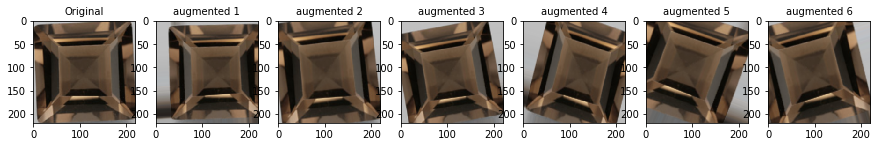

In [21]:
n = randint(0,len(X_train))
samples = np.expand_dims(X_train[n], 0)
it = train_datagen.flow(samples, batch_size=batch_size)
cols = 7

fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(15, 10))
ax[0].imshow(X_train[n], cmap='gray')
ax[0].set_title('Original', fontsize=10)

for i in range(1,cols):
    batch = it.next()    # generate batch of images 
    image = batch[0].astype('uint32') # convert to unsigned int for viewing
    ax[i].set_title('augmented {}'.format(i), fontsize=10)
    ax[i].imshow(image, cmap='gray')

Create two numpy array iterators `train_gen` and `val_gen` and fill them with additional images:

In [22]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_gen = val_datagen.flow(X_val, y_val, batch_size=batch_size)

## 2. Fit the model
* get a history object
* If you see that `val_los` parameter is increasing that is *overfitting*. It happens when your model explains the training data too well, rather than picking up patterns that can help generalize over unseen data.

In [ ]:
m = model.fit_generator(
       train_gen,
       steps_per_epoch= iter_per_epoch,
       epochs=EPOCHS, 
       validation_data = val_gen,
       validation_steps = val_per_epoch,
       verbose = 1 # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
       )

Epoch 1/70
71/71 [==============================] - 23s 317ms/step - loss: 4.4607 - accuracy: 0.0648 - val_loss: 3.5238 - val_accuracy: 0.1158
Epoch 2/70
71/71 [==============================] - 20s 288ms/step - loss: 3.0767 - accuracy: 0.1750 - val_loss: 2.4748 - val_accuracy: 0.2352
Epoch 3/70
71/71 [==============================] - 20s 280ms/step - loss: 2.5489 - accuracy: 0.2620 - val_loss: 2.6683 - val_accuracy: 0.2944
Epoch 4/70
71/71 [==============================] - 20s 286ms/step - loss: 2.3068 - accuracy: 0.3171 - val_loss: 2.1430 - val_accuracy: 0.3148
Epoch 5/70
71/71 [==============================] - 20s 279ms/step - loss: 2.2105 - accuracy: 0.3339 - val_loss: 2.0202 - val_accuracy: 0.3315
Epoch 6/70
71/71 [==============================] - 20s 286ms/step - loss: 2.0524 - accuracy: 0.3774 - val_loss: 2.0089 - val_accuracy: 0.3667
Epoch 7/70
71/71 [==============================] - 20s 287ms/step - loss: 1.9177 - accuracy: 0.4156 - val_loss: 1.8722 - val_accuracy: 0.3667

**ALMOST DONE!** 😈   

## 3. Check the accuracy

* plot the accuracy of model against size of epoch (train and val);
* plot the loss of model against size of epoch (train and val).

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axs[0].plot(m.history['accuracy'])
axs[0].plot(m.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].legend(['Train', 'Val'], loc='upper left')

axs[1].plot(m.history['loss'])
axs[1].plot(m.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].legend(['Train', 'Val'], loc='upper left')

for ax in axs.flat:
    ax.set(xlabel='Epoch')

* there is an overfitting: even though train and val accuracy are pretty close to each other, `val_loss` parameter often 'jumps'.

## 4. Score the model
> Accuracy is a metric for evaluating classification models. `Accuracy  = Number of right predictions / Total number of predictions`.

* Function `evaluate_generator` evaluates the model on a data generator: `score` is a list of scalars (loss and accuracy).

In [ ]:
score = model.evaluate_generator(val_gen, steps= len(val_gen))

for idx, metric in enumerate(model.metrics_names):
    print('{}:{}'.format(metric, score[idx]))

The accuracy of a model from scratch ~ 65%. Any suggestions on improving a model are taking up 😊

## 5. Confusion matrix   
> Confusion matrix can be pretty useful when evaluating multiclass classifications.   

* `from sklearn.metrics import confusion_matrix`: Diagonal of matrix should be mostly filled with numbers.

In [ ]:
from sklearn.metrics import confusion_matrix
y_pre_test=model.predict(X_val)
y_pre_test=np.argmax(y_pre_test,axis=1)
cm=confusion_matrix(y_val,y_pre_test)

plt.figure(figsize = (15,15))
sn.heatmap(cm, annot=True)

Because of great amount of classes just **plot misclassified gemstones by model**. `numpy.argmax()` function returns the indices of maximum elements along the specific axis inside the array (`axis = 1` - 'horizontally').
* Create a list of misclassified indexes which will be substitued into validation set `X_val`.  
* Plot misclassified gemstones.

In [ ]:
x=(y_pre_test-y_val!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

fig,ax=plt.subplots(1,5,sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(5):
    ax[i].imshow(X_val[x[i]][:,:,1])
    ax[i].set_xlabel('{}, Pred: {}'.format(CLASSES[y_val[x[i]]],CLASSES[y_pre_test[x[i]]]))

Don't judge poor model. Just look at `Almandine`, `Garnet Red`, `Hessonite`, `Pyrope` and `Rhodolite`. Can you distinguish between them?

In [ ]:
red_stones = ['Almandine', 'Garnet Red', 'Hessonite', 'Pyrope', 'Rhodolite']
red_stones = get_class_index(red_stones)

fig,ax=plt.subplots(1,len(red_stones),sharey=False,figsize=(13,13))
fig.tight_layout()

for i in range(len(red_stones)):
    ax[i].imshow(Train_Imgs[np.where(Train_Lbls==red_stones[i])[0][1]])
    ax[i].set_xlabel(CLASSES[red_stones[i]])

## 6. Save the model
* Save weights to reuse them instead of training again. Keras function `save` creates h5 file with weights. Use `new_model.load_weights('model_gemstones.h5')` to reuse it in other models.

In [ ]:
model.save('model_gemstones.h5')

# IV. Evaluate on testing folder

## 1. Get samples from test folder
Create test data generator using class `ImageDataGenerator` and validate it providing the test directory `'/kaggle/input/gemstones-images/test/'`

In [ ]:
test_dir = '/kaggle/input/gemstones-images/test/'

Create `Test_Imgs` and `Test_Lbls` absolutely the same as we did with training folder. Convert them to numpy arrays - there are 358 images for test. `Test_Lbls` array will help to check is the model predictions are correct.

In [ ]:
Test_Imgs, Test_Lbls = read_imgs_lbls(test_dir)
Test_Lbls = get_class_index(Test_Lbls)

## 2. Crop test images

In [ ]:
Test_Imgs = crop_images(Test_Imgs)
print('shape of images in test set: {} '.format(Test_Imgs.shape))

## 2. Plot test images and model predictions
Plot image from test folder with a label, class which model predicted, and actual class.

In [ ]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,2,2)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Test_Imgs))
        pred_image = np.array([Test_Imgs[rnd_number]])
        pred_class = model.predict_classes(pred_image)[0]
        pred_prob = model.predict(pred_image).reshape(87)
        act = CLASSES[Test_Lbls[rnd_number]]
        ax[i,j].imshow(Test_Imgs[rnd_number])
        ax[i,j].imshow(pred_image[0])
        if(CLASSES[pred_class] != CLASSES[Test_Lbls[rnd_number]]):
            t = '{} [{}]'.format(CLASSES[pred_class], CLASSES[Test_Lbls[rnd_number]])
            ax[i,j].set_title(t, fontdict={'color': 'darkred'})
        else:
            t = '[OK] {}'.format(CLASSES[pred_class]) 
            ax[i,j].set_title(t)
        ax[i,j].axis('off')

# Conclusion

The model tries! Finally it understands the color: some gemstones are really similar.  


![Diamonds? really?](https://cdn.leibish.com/media/mediabank/blue-diamond-scale_1634.c8fbb.jpg)


### **Please upvote this kernel if you find it useful** 🙋  
Feel free to give any suggestions to improve my code.